Case Study 
==================
**Purpose**: Build  classification model to predict the probability that customer will subscribe a term deposit.

**Author**: Fei He



----- Configuration -----
------------------

In [2]:

# Common imports
import os
import numpy as np
# to make this notebook's output stable across runs
np.random.seed(42)


# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals


# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
import seaborn as sns
#sns.set_style("whitegrid")
#sns.set_context("poster")


# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings
import warnings
#warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
warnings.filterwarnings('ignore')


# Python model  package needed

import pandas as pd
from random import randint
import math
from scipy import stats, integrate
import time
from sklearn.externals import joblib

# model  
#from sklearn.linear_model import SGDClassifier, LogisticRegression
#from sklearn.svm import SVC, LinearSVC
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, ExtraTreesClassifier,VotingClassifier
#from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb

# evaluation 
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score, GridSearchCV,RandomizedSearchCV,cross_validate, KFold
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,classification_report,f1_score,recall_score,precision_score,accuracy_score,precision_recall_curve,roc_curve,roc_auc_score
#from sklearn import metrics
import scikitplot as skplt

----- Get the data -----
------------------

In [3]:
# Import data
df= pd.read_csv('./data/bank/bank.csv', engine='python',index_col=False, header=None, delimiter='\;').replace('"','', regex=True)
# set up first row as column name 
df.columns = df.iloc[0]
# remove first row which contains header
df = df.drop(index=0).reset_index(drop=True)
# drop last blank column
df=df.iloc[:,0:-1]
# what data looks like
df.tail(5)


,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
42595,28,unemployed,single,NULL,no,0,no,NULL,cellular,6,feb,15,9,-1,0,unknown,no
42596,NULL,blue-collar,married,NULL,no,175,yes,NULL,cellular,4,feb,430,2,272,3,other,no
42597,NULL,blue-collar,married,NULL,no,4,yes,NULL,cellular,8,jul,173,1,-1,0,unknown,no
42598,43,management,married,NULL,no,704,no,NULL,cellular,18,jul,116,1,-1,0,unknown,no
42599,49,management,single,NULL,no,-18,yes,NULL,cellular,11,may,217,3,264,4,failure,no


----Prepare the Data----
--------------------------


In [3]:
df.head(5)
test=df.copy()

#### step1  Feature generation 

In [4]:
# summary : function to clean data 
# step1 
def bi_var(x):
    if x=='yes':
        return 1
    else:
        return 0
    
def day_wk(x):
    if 0<=x<=15:
        return 1
    elif 15<x<=31:
        return 2
    else:
        return -99
    
def job(x):
    if x in ['unemployed', 'self-employed','NULL','unknown'] : return '0-unemploymed/self/unknown/admin'
    elif x in ['housemaid','services'] : return 'housemaid/service'
    elif x in ['retired','student']: return 'retired/student'
    elif x in  ['entrepreneur','management']: return 'management/enterpreneur'
    else : return x

def qrt(x):  
    if x in ['jan','feb','mar']:return 1 
    elif x in ['apr','may' ,'jun']:return 2 
    elif x in ['jul', 'aug','sep']: return 3
    else: return 4
    

def pre_clean(df,num_var) :
    print ('\n-------------Prepare datasets ----------------')
    var=df.iloc[:,0:-1].columns.tolist()
    # numerical var 
    num_var=num_var
    # convert numberical to char 
    num_df = df[num_var].apply(pd.to_numeric, errors='coerce')
    # char var
    char_var=[x for x in var if not x in num_var]
    char_df=df[char_var]
    # combine datasts 
    df2=pd.concat([num_df,char_df],axis=1)
    
    print ('\n-------------Feature engineering----------------')
    # convert day to 2  levels
    df2['day_ind']=num_df['day'].apply(day_wk)
    # 1 indicate positive balance  
    df2['balance_ind']=df2['balance'].apply(lambda x : 1 if x >=0 else 0 )
    # 1 indicate not contact previously 
    df2['pdays_no_ind']=df2['pdays'].apply(lambda x : 1 if x <0 else 0 )
    # create indicator for married or not 
    df2['marital_ind']=np.where(df2['marital']=='married',1,0)  
    df2['education']=df2['education'].replace('NULL', 'unknown')   
    df2['job_grp']=df2['job'].apply(job) 
    df2['loan_ind']=df2['loan'].apply(bi_var)
    df2['housing_ind']=df2['housing'].apply(bi_var)
    df2['default_ind']=df2['default'].apply(bi_var)
    df2['contact_cell_ind']=df2['contact'].apply(lambda x: 1 if x in ['cellular'] else 0)
    df2['poutcome_suc_ind']=df2['poutcome'].apply(lambda x: 1 if x in ['success'] else 0)
    df2['qtr'] = df2['month'].apply(qrt)   
    print ('\n------------target convert---------------------')
    # convert char to num to calculate target rate
    df2['y']=np.where(df['y']=='yes', 1,0)
    print ('\n-----------drop data error ------------------------')
    # remove 3 records with duration=0 ?
    df3=df2.loc[df2['duration']!=0]

    return df3

In [5]:
# data -precleaning 
num_var=['age','balance','day','duration', 'campaign', 'pdays', 'previous']
data=pre_clean(test,num_var)


-------------Prepare datasets ----------------

-------------Feature engineering----------------

------------target convert---------------------

-----------drop data error ------------------------


#### step 2 Quantile binning for continous variables 

In [6]:
# numeric vairables binning (quantile binning)
def num_bin(df, s, q):
    df[s+'_bin'] = pd.qcut(df.loc[df[s].notnull()][s],q = q, labels = False, duplicates = 'drop')
    df.loc[df[s].isnull(), s+'_bin'] = 99
    gr=df.groupby([s+'_bin']).agg({s:['min','max','size']})
    display(gr)
    return df
def num_bin2(df, s, q):
    df[s+'_bin'] = pd.qcut(df.loc[df[s]!=-1][s],q = q, labels = False, duplicates = 'drop')
    df.loc[df[s]==-1 , s+'_bin'] = 99
    gr=df.groupby([s+'_bin']).agg({s:['min','max','size']})
    display(gr)
    return df
def num_bin3(df, s, q):
    df[s+'_bin'] = pd.qcut(df.loc[df[s]!=0][s],q = q, labels = False, duplicates = 'drop')
    df.loc[df[s]==0 , s+'_bin'] = 99
    gr=df.groupby([s+'_bin']).agg({s:['min','max','size']})
    display(gr)
    return df

In [7]:
def quatile_bin(a):
    num_bin(a,'age',4)
    num_bin(a,'balance',7)
    num_bin(a,'campaign',7)
    num_bin2(a,'pdays',3)
    num_bin3(a,'previous',4)
  

In [8]:
quatile_bin(data)
var_bin=[col for col in data if col.endswith('_bin')]
# check graph 
# for x in var_bin:
#     catplot(data,x,'y',  plot=True)

age             
          min   max   size
age_bin                   
0.0      18.0  33.0  11456
1.0      34.0  39.0   9250
2.0      40.0  48.0   9639
3.0      49.0  95.0   9596
99.0      NaN   NaN   2656

balance              
                min     max  size
balance_bin                      
0             -8019       0  7078
1                 1     104  5126
2               105     304  6055
3               305     598  6100
4               599    1164  6069
5              1165    2582  6084
6              2583  102127  6085

campaign           
                  min max   size
campaign_bin                    
0                   1   2  27941
1                   3   3   5253
2                   4   4   3402
3                   5  63   6001

pdays            
            min  max   size
pdays_bin                  
0.0           1  175   2317
1.0         176  299   2235
2.0         300  850   2272
99.0         -1   -1  35773

previous            
                  min  max   size
previous_bin                     
0.0                 1    2   4114
1.0                 3    4   1493
2.0                 5  275   1217
99.0                0    0  35773

In [12]:
obj_df = data.select_dtypes(include=['object']).copy()
print (obj_df.columns.tolist() ) 


['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job_grp']


#### step 3 Create dummy variable for categorical variables  

In [13]:
# regression need drop one level while tree based model don't 
dumy_var=['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'job_grp']
final = pd.get_dummies(data, columns =dumy_var, drop_first = False )

####  step4 Split data to train and test 


In [14]:
# Split training and testing
#x = data.iloc[:,0:-1]
x=final
y, _ = pd.factorize(data['y'])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=1234)
# Tag rate
test =  pd.DataFrame(y_train)
test.columns = ['y']
tot_tag_rate = test['y'].sum()*1.0/test.shape[0]
print('Training tag rate %s' % (tot_tag_rate))
print('Training records %s' % (test.shape[0]))

test =  pd.DataFrame(y_test)
test.columns = ['y']
tot_tag_rate = test['y'].sum()*1.0/test.shape[0]
print('Testing tag rate %s' % (tot_tag_rate))
print('Testing tag rate %s' % (test.shape[0]))

Training tag rate 0.09729349029077372
Training records 29817
Testing tag rate 0.10164319248826291
Testing tag rate 12780


#### step5  Age imputation 

In [15]:
# imputation for age 
median = x_train.iloc[:,0].median()
x_train['age_impute']=x_train['age'].fillna(median) 
x_test['age_impute']=x_test['age'].fillna(median) 

In [16]:
#X_train[X_train['age'].isnull()].head(5)
x_test[x_test['age'].isnull()].head(5)

,age,balance,day,duration,campaign,pdays,previous,day_ind,balance_ind,pdays_no_ind,...,poutcome_success,poutcome_unknown,job_grp_0-unemploymed/self/unknown/admin,job_grp_admin.,job_grp_blue-collar,job_grp_housemaid/service,job_grp_management/enterpreneur,job_grp_retired/student,job_grp_technician,age_impute
27721,NaN,1688,7,41,4,-1,0,1,1,1,...,0,1,0,0,1,0,0,0,0,39.0
16883,NaN,3665,12,664,3,-1,0,1,1,1,...,0,1,0,0,0,0,0,0,1,39.0
33662,NaN,182,13,38,3,-1,0,1,1,1,...,0,1,0,0,0,1,0,0,0,39.0
16528,NaN,9965,22,662,1,-1,0,2,1,1,...,0,1,0,0,0,1,0,0,0,39.0
31882,NaN,1176,21,166,2,-1,0,2,1,1,...,0,1,0,0,1,0,0,0,0,39.0


In [17]:
# # of variables 
len(x_train.columns.tolist())

78

####  step6  Make feature  in the same scale 

In [18]:
###   make feature  in the same scale 
print('standardlize the data') 
scaler = StandardScaler()
## variable need scale 
scale_var=x_train.drop('y',axis=1).columns.tolist()
# make normalization on x_train,x_valid and x_test dataset
X_train = pd.DataFrame(scaler.fit_transform(x_train[scale_var]),index=x_train[scale_var].index, columns=x_train[scale_var].columns)
X_test = pd.DataFrame(scaler.fit_transform(x_test[scale_var]),index=x_test[scale_var].index, columns=x_test[scale_var].columns.values)


standardlize the data


In [19]:
var_keep=[ #'age',
 #'balance',
 #'day',   
 'duration',
#  'campaign',
#  'pdays',
#  'previous',
 'day_ind',
 'balance_ind',
 'pdays_no_ind',
 'marital_ind',
 'loan_ind',
 'housing_ind',
 'default_ind',
 'contact_cell_ind',
 'poutcome_suc_ind',
 'qtr',
 'age_bin',
 'balance_bin',
 'campaign_bin',
 'pdays_bin',
 'previous_bin',    
#  'job_admin.',
#  'job_blue-collar',
#  'job_entrepreneur',
#  'job_housemaid',
#  'job_management',
#  'job_retired',
#  'job_self-employed',
#  'job_services',
#  'job_student',
#  'job_technician',
#  'job_unemployed',
#  'job_unknown',
#  'marital_divorced',
#  'marital_married',
#  'marital_single',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
#  'default_yes',
#  'housing_yes',
#  'loan_no',
#  'loan_yes',
#  'contact_telephone',
#  'contact_unknown',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
#  'poutcome_other',
#  'poutcome_success',
#  'poutcome_unknown',
 'job_grp_admin.',
 'job_grp_blue-collar',
 'job_grp_housemaid/service',
 'job_grp_management/enterpreneur',
 'job_grp_retired/student',
 'job_grp_technician',
# 'age_impute'
]

In [20]:
len(var_keep)

36

In [21]:
var_rf_keep=[
 #   'age',
 #'balance',
 #'day',
 'duration',
 #'campaign',
 #'pdays',
 #'previous',
 'day_ind',
 'balance_ind',
 'pdays_no_ind',
 'marital_ind',
 'loan_ind',
 'housing_ind',
 'default_ind',
 'contact_cell_ind',
 'poutcome_suc_ind',
 'qtr',
 #'age_bin',
 'balance_bin',
 'campaign_bin',
 'pdays_bin',
 'previous_bin',
 'job_NULL',
 'job_admin.',
 'job_blue-collar',
 'job_entrepreneur',
 'job_housemaid',
 'job_management',
 'job_retired',
 'job_self-employed',
 'job_services',
 'job_student',
 'job_technician',
 'job_unemployed',
 'job_unknown',
#  'marital_NULL',
#  'marital_divorced',
#  'marital_married',
#  'marital_single',
 'education_primary',
 'education_secondary',
 'education_tertiary',
 'education_unknown',
#  'default_no',
#  'default_yes',
#  'housing_no',
#  'housing_yes',
#  'loan_NULL',
#  'loan_no',
#  'loan_yes',
#  'contact_cellular',
#  'contact_telephone',
#  'contact_unknown',
 'month_apr',
 'month_aug',
 'month_dec',
 'month_feb',
 'month_jan',
 'month_jul',
 'month_jun',
 'month_mar',
 'month_may',
 'month_nov',
 'month_oct',
 'month_sep',
#  'poutcome_failure',
#  'poutcome_other',
#  'poutcome_success',
#  'poutcome_unknown',
#  'job_grp_0-unemploymed/self/unknown/admin',
#  'job_grp_admin.',
#  'job_grp_blue-collar',
#  'job_grp_housemaid/service',
#  'job_grp_management/enterpreneur',
#  'job_grp_retired/student',
#  'job_grp_technician',
 'age_impute']

----- Feature selection -----
---

In [22]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier()
x = X_train[var_keep]

model.fit(x, y_train)

importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature ranking:")
var_importance = []
for f in range(x.shape[1]):
    print(("%d. feature " + str(x.columns.values[indices[f]]) + " (%f)") % (f + 1, importances[indices[f]]))
    var_importance.append([str(x.columns.values[indices[f]]),importances[indices[f]]/sum(importances)])

Feature ranking:
1. feature duration (0.317292)
2. feature balance_bin (0.087142)
3. feature age_bin (0.079597)
4. feature poutcome_suc_ind (0.045414)
5. feature campaign_bin (0.044211)
6. feature day_ind (0.038230)
7. feature housing_ind (0.024447)
8. feature marital_ind (0.024415)
9. feature education_secondary (0.021711)
10. feature qtr (0.020906)
11. feature pdays_bin (0.018215)
12. feature job_grp_management/enterpreneur (0.017886)
13. feature previous_bin (0.017732)
14. feature contact_cell_ind (0.017624)
15. feature job_grp_technician (0.016362)
16. feature education_tertiary (0.016239)
17. feature loan_ind (0.016121)
18. feature job_grp_admin. (0.014174)
19. feature job_grp_blue-collar (0.013470)
20. feature month_jun (0.013153)
21. feature month_mar (0.012897)
22. feature month_may (0.012279)
23. feature job_grp_housemaid/service (0.011740)
24. feature job_grp_retired/student (0.011253)
25. feature month_oct (0.010757)
26. feature education_unknown (0.010448)
27. feature month

In [23]:
# choose top 20 features 
from operator import itemgetter
#print sorted(var_importance, key=itemgetter(1), reverse = True)
l = sorted(var_importance, key=itemgetter(1), reverse = True)
#remove zero importance variables
var_treeselect = [i[0] for i in l if i[1] >= 0.01]
print("number of features selected: %d" % len(var_treeselect))

number of features selected: 26


----- Modeling  -----
---

In [24]:
# Funtions to get Evaluation metrics

def build_model_train_test(model,x_train,x_test,y_train,y_test):
    start = time.time()
    model.fit(x_train,y_train)
    
    print("\n----------Accuracy Scores on Train data------------------------------------")
    
    y_pred = model.predict(x_train)
    y_pred_prob = model.predict_proba(x_train)[:, 1]
    print("F1 Score: ", f1_score(y_train,y_pred))
    print("Precision Score: ", precision_score(y_train,y_pred))
    print("Recall Score: ", recall_score(y_train,y_pred))

    print("AUC: ",roc_auc_score(y_train,y_pred_prob))

    print("\n----------Accuracy Scores on Cross validation data----------------------------")
    y_pred_cv = cross_val_predict(model,x_train,y_train,cv=5)
    y_pred_cv_pb = cross_val_predict(model,x_train,y_train,cv=5, method='predict_proba')[:,1]
    print("F1 Score: ", f1_score(y_train,y_pred_cv))
    print("Precision Score: ", precision_score(y_train,y_pred_cv))
    print("Recall Score: ", recall_score(y_train,y_pred_cv))
    print("AUC: ",roc_auc_score(y_train,y_pred_cv_pb))

    print("\n----------Accuracy Scores on Test data------------------------------------")
    y_pred_test = model.predict(x_test)
    y_pred_test_prob = model.predict_proba(x_test)[:, 1]


    print("F1 Score: ", f1_score(y_test,y_pred_test))
    print("Precision Score: ", precision_score(y_test,y_pred_test))
    print("Recall Score: ", recall_score(y_test,y_pred_test))
    print("AUC: ",roc_auc_score(y_test,y_pred_test_prob))
    #print("AUC: ",roc_auc_score(y_test,y_pred_test))
    end = time.time()
    print("Time taken by above cell is {}.".format((end-start)))
    
    print("\n----------Charts------------------------------------")
    probas = model.predict_proba(x_test)
    import scikitplot as skplt
    skplt.metrics.plot_lift_curve(y_test, probas)
    skplt.metrics.plot_cumulative_gain(y_test, probas)
    skplt.metrics.plot_ks_statistic(y_test, probas)


In [25]:
# use cross validation to optimize  probability threshold for Precision and Recall
def SelectThresholdByCV(probs,y):
    best_threshold = 0
    best_f1 = 0
    f = 0
    precision =0
    recall=0
    best_recall = 0
    best_precision = 0
    precisions=[]
    recalls=[]
    
    thresholds = np.arange(0.0,1.0,0.001)
    for threshold in thresholds:
        predictions = (probs > threshold)
        f = f1_score(y, predictions)
        precision = precision_score(y, predictions)
        recall = recall_score(y, predictions)
        #print("Threshold {0},Precision {1},Recall {2}".format(threshold,precision,recall))
        
        if f > best_f1:
            best_f1 = f
            best_precision = precision
            best_recall = recall
            best_threshold = threshold

        precisions.append(precision)
        recalls.append(recall)

    #Precision-Recall Trade-off
    plt.plot(thresholds,precisions,label='Precision')
    plt.plot(thresholds,recalls,label='Recall')
    plt.xlabel("Threshold")
    plt.title('Precision Recall Trade Off')
    plt.legend()
    plt.show()

    print ('Best F1 Score %f' %best_f1)
    print ('Best Precision Score %f' %best_precision)
    print ('Best Recall Score %f' %best_recall)
    print ('Best Epsilon Score', best_threshold)
    
def Print_Accuracy_Scores(y,y_pred):
    print("F1 Score: ", f1_score(y,y_pred))
    print("Precision Score: ", precision_score(y,y_pred))
    print("Recall Score: ", recall_score(y,y_pred))
    

## Approach 1 : Try different classfication algorithms 
  Applied mutiple models on the data, did error analysis & tried to improve model performance.

### Baseline model 


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.43151369726054795
Precision Score:  0.5138095238095238
Recall Score:  0.37194071009996554
AUC:  0.8400972046320369

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.4316776381408338
Precision Score:  0.5123106060606061
Recall Score:  0.3729748362633575
AUC:  0.8380130013945616

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.4341507720254314
Precision Score:  0.5293466223698782
Recall Score:  0.36797536566589684
AUC:  0.8333910314990414
Time taken by above cell is 0.5216050148010254.

----------Charts------------------------------------


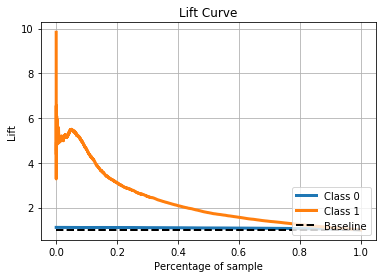

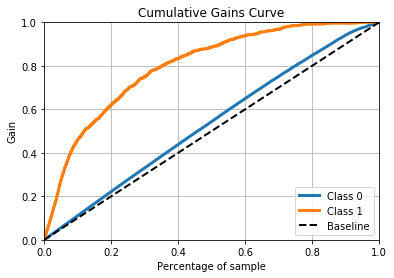

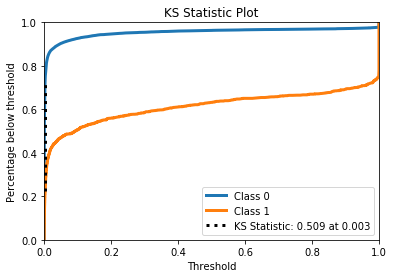

In [26]:
##  run a very quick NN base to see how the data look like , AUC 0.83 .
from sklearn.naive_bayes import GaussianNB
nn_clf =GaussianNB()
build_model_train_test(nn_clf,X_train[var_treeselect],X_test[var_treeselect],y_train,y_test)
# slow running time 

### Logistical regression 


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.5004290004290005
Precision Score:  0.3632259068970886
Recall Score:  0.8042054463977939
AUC:  0.9094521485229957

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.4986072423398329
Precision Score:  0.3617285869734183
Recall Score:  0.80213719407101
AUC:  0.9078513392028585

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.5128585558852621
Precision Score:  0.37777777777777777
Recall Score:  0.798306389530408
AUC:  0.9057757104333907
Time taken by above cell is 1.093047857284546.

----------Charts------------------------------------

--------- Feature importance-----------------------------------
pdays_bin                          1.000000
previous_bin                       0.927353
duration                           0.578037
contact_cell_ind                   0.170787
housing_ind                        0.148036
poutc

['./lr_model.pkl']

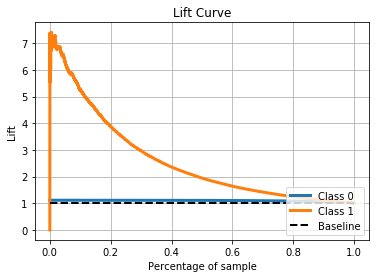

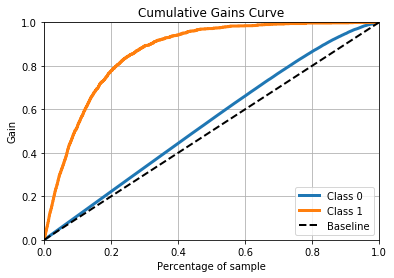

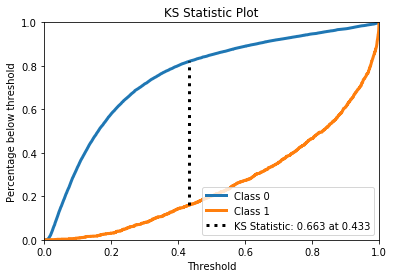

In [27]:
# logistical regression , add balanced option , recall increased !
lr_clf = LogisticRegression(penalty = 'l2',class_weight='balanced',random_state=1234)
build_model_train_test(lr_clf,X_train[var_treeselect],X_test[var_treeselect],y_train,y_test)

print("\n--------- Feature importance-----------------------------------")

feature_importance = abs(lr_clf.coef_[0])
feature_importance = 1.0 * (feature_importance / feature_importance.max())
featimp = pd.Series(feature_importance ,index=X_train[var_treeselect].columns).sort_values(ascending=False)
print(featimp)
joblib.dump(lr_clf ,'./lr_model.pkl')

- Logistical regression with option class_weight='balanced', have high recall 80 and AUC 90.5, KS 66  which are good 
- I'd like to improve the recall score further. So let us use predict_proba to get the probabilities and see if we can improve the recall by using a different threshold.

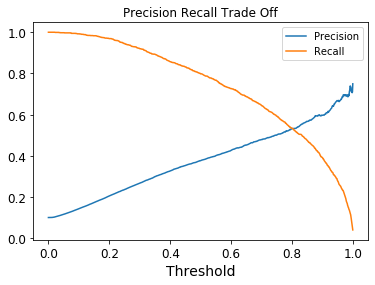

Best F1 Score 0.551545
Best Precision Score 0.477477
Best Recall Score 0.652810
Best Epsilon Score 0.6920000000000001


In [29]:
#Probability score for each record for prediction
probs_lr_test = lr_clf.predict_proba(X_test[var_treeselect])
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_lr_test[:,1],y_test)

In [30]:
y_pred_test = (probs_lr_test[:,1] > 0.6920000000000001)
Print_Accuracy_Scores(y_test,y_pred_test)

F1 Score:  0.5515447154471544
Precision Score:  0.4774774774774775
Recall Score:  0.6528098537336413


- By setting different thresthod , we decease recall from 80 to 65, but precision increase from 38 to 47.
- The model has given the  best results with 65  recall score and 47 precision score at 0.692 threshold.

### XG Boost


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.7119251443360541
Precision Score:  0.8426013195098964
Recall Score:  0.6163391933815926
AUC:  0.9742196975855892

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.4892966360856269
Precision Score:  0.5988023952095808
Recall Score:  0.4136504653567735
AUC:  0.9304125992804916

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.5009380863039399
Precision Score:  0.6410564225690276
Recall Score:  0.4110854503464203
AUC:  0.9296835706534993
Time taken by above cell is 79.71699976921082.

----------Charts------------------------------------

--------- Feature importance-----------------------------------
duration                           0.314169
balance_bin                        0.090002
age_bin                            0.061464
day_ind                            0.046046
qtr                                0.044217
mar

['./xgb_model.pkl']

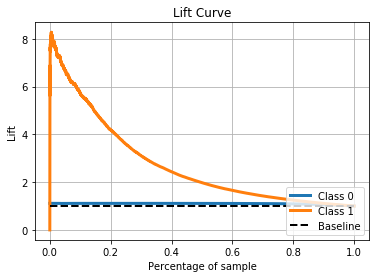

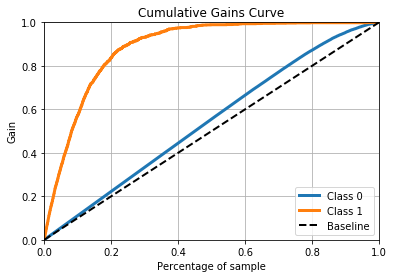

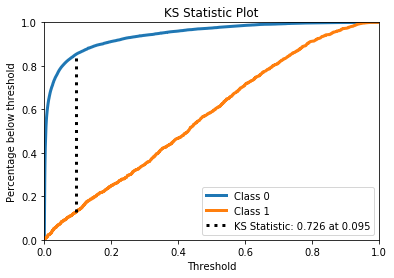

In [31]:
from xgboost import XGBClassifier

#xgb_clf = XGBClassifier(random_state=0,reg_alpha = 0)
xgb_clf = XGBClassifier(max_depth  = 10, learning_rate = 0.05, n_estimators = 200, n_jobs = -1, min_child_weight = 5, subsample = 1, random_state=0, reg_alpha = 0,  seed = 42)
build_model_train_test(xgb_clf,X_train[var_keep],X_test[var_keep],y_train,y_test)
print("\n--------- Feature importance-----------------------------------")
featimp = pd.Series(xgb_clf.feature_importances_,index=X_train[var_keep].columns).sort_values(ascending=False)
print(featimp)
# save this model 
joblib.dump(xgb_clf ,'./xgb_model.pkl')

In [33]:
## Top features selected by XG boost model 
xgb_f=featimp.to_frame().reset_index()
xgb_f = xgb_f.rename(columns= {0: 'rev_imp'})
xgb_f.head(10)

,index,rev_imp
0,duration,0.314169
1,balance_bin,0.090002
2,age_bin,0.061464
3,day_ind,0.046046
4,qtr,0.044217
5,marital_ind,0.034548
6,housing_ind,0.033555
7,contact_cell_ind,0.030262
8,campaign_bin,0.028746
9,education_secondary,0.026290


- XGboost with default parameters( L1 -lasso), give us high precision 64 but low recall 41. also give us higher AUC 93 compared to LR
- I'd like to improve the recall score. So let us use predict_proba to get the probabilities and see if we can improve the recall by using a different threshold.

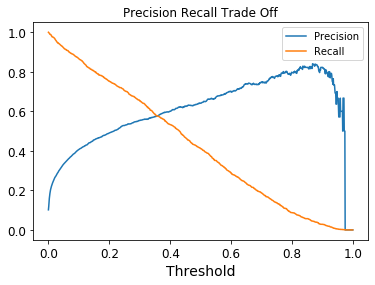

Best F1 Score 0.606675
Best Precision Score 0.527604
Best Recall Score 0.713626
Best Epsilon Score 0.244


In [34]:
#Probability score for each record for prediction
probs_xgb_test = xgb_clf.predict_proba(X_test[var_keep])
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_xgb_test[:,1],y_test)

In [35]:
y_pred_test = (probs_xgb_test[:,1] > 0.244)
Print_Accuracy_Scores(y_test,y_pred_test)

F1 Score:  0.6066753926701571
Precision Score:  0.5276038702333523
Recall Score:  0.7136258660508084


The model has given the  best results with 71  recall score and 52 precision score at 0.244 threshold.

### Random Forest 


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.52024312351911
Precision Score:  0.3709961798413165
Recall Score:  0.8703895208548776
AUC:  0.926326515129045

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.5084745762711864
Precision Score:  0.36215978928884984
Recall Score:  0.8531540847983454
AUC:  0.9162284232396073

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.5239923224568138
Precision Score:  0.3806204252352736
Recall Score:  0.8406466512702079
AUC:  0.9136979602608829
Time taken by above cell is 13.131175518035889.

----------Charts------------------------------------

--------- Feature importance-----------------------------------
duration               0.474633
poutcome_suc_ind       0.078005
contact_cell_ind       0.050828
housing_ind            0.046810
pdays_bin              0.037562
age_impute             0.036165
previous_bin           0.035284


['./rnd_model.pkl']

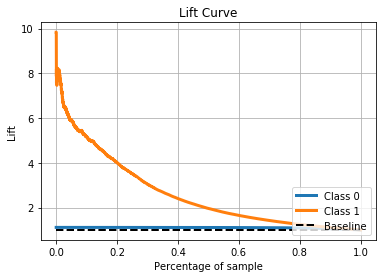

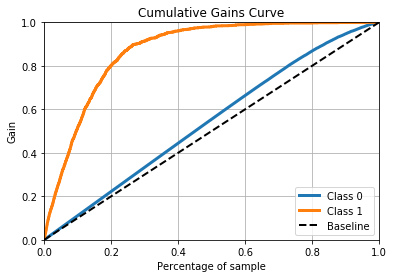

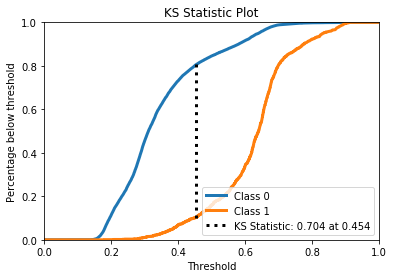

In [36]:
# AUC is higher than logistical Regression  
# Precision is high but recall is low , KS is low
#Precision high and recall is low -due to imbalance data? 
rnd_clf = RandomForestClassifier(max_depth  = 6,n_estimators=200,criterion='gini',n_jobs=-1, class_weight='balanced',random_state=0,)
build_model_train_test(rnd_clf,X_train[var_rf_keep],X_test[var_rf_keep],y_train,y_test)

print("\n--------- Feature importance-----------------------------------")
featimp = pd.Series(rnd_clf.feature_importances_,index=X_train[var_rf_keep].columns).sort_values(ascending=False)
print(featimp)

# save this model 
joblib.dump(rnd_clf ,'./rnd_model.pkl')

- RF model give us high recall  84  but low precision 38. also give us higher AUC 91  compared to LR
- I'd like to improve the precision score. So let us use predict_proba to get the probabilities and see if we can improve the precision  by using a different threshold.

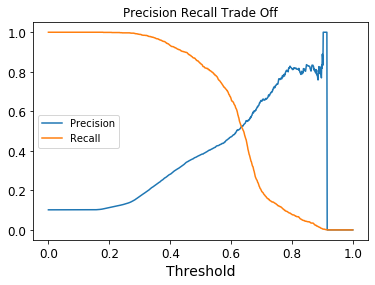

Best F1 Score 0.554576
Best Precision Score 0.458291
Best Recall Score 0.702079
Best Epsilon Score 0.588


In [37]:
#Probability score for each record for prediction
probs_rf_test = rnd_clf.predict_proba(X_test[var_rf_keep])
#Choose the best probability threshold where F1-score is highest
SelectThresholdByCV(probs_rf_test[:,1],y_test)

In [38]:
# cut-off at 0.245 
y_pred_test = (probs_rf_test[:,1] > 0.588)
Print_Accuracy_Scores(y_test,y_pred_test)

F1 Score:  0.554575858923685
Precision Score:  0.45829145728643217
Recall Score:  0.7020785219399538


- By setting different thresthod , we decease recall from 84 to 70, but precision increase from 38 to 45.
- The model has given the  best results with 70  recall score and 45 precision score at 0.588 threshold.

## Approach 2 : Oversampling -SMOTE
   Balance minority class ( 10% of subscribe rate) 


----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.9093222009209323
Precision Score:  0.8781534415337232
Recall Score:  0.9427849606182196
AUC:  0.9653163410851294

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.9030492712152374
Precision Score:  0.8706162281457981
Recall Score:  0.9379922722544212
AUC:  0.9618522227063271

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.20820853234032216
Precision Score:  0.1163379772028225
Recall Score:  0.9899923017705927
AUC:  0.8001947723785572
Time taken by above cell is 28.901875495910645.

----------Charts------------------------------------


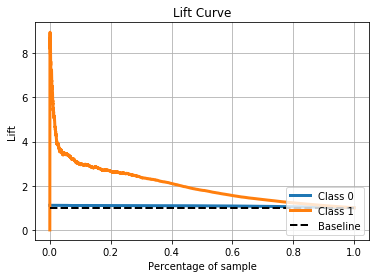

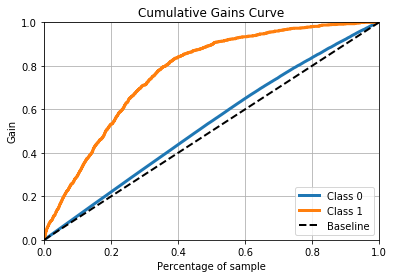

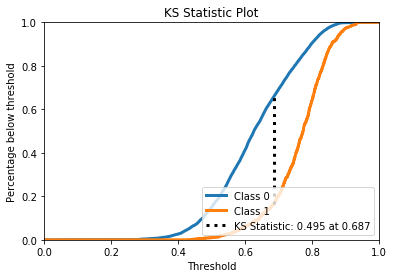

In [39]:
## over-sampling using SMOTE

from imblearn.over_sampling import SMOTE
from collections import Counter
from imblearn.combine import SMOTETomek

os =  SMOTE(random_state=0)
#os= SMOTETomek(random_state=0)
#Generate the oversample data
os_res_x,os_res_y=os.fit_sample(X_train[var_rf_keep],y_train)

#Counts of each class in oversampled data
#print(sorted(Counter(os_res_y).items()))

#RandomForest for training over-sampled data set. 
#Note: we have removed class_weight='balanced' since the data is balanced using SMOTE.
#rnd_clf = RandomForestClassifier(n_estimators=200,criterion='gini',n_jobs=-1, random_state=0)
rnd_clf = RandomForestClassifier(max_depth  = 6,n_estimators=200,criterion='gini',n_jobs=-1,random_state=0,)

#Train the model on oversampled data and check the performance on actual test data
build_model_train_test(rnd_clf,os_res_x,X_test[var_rf_keep],os_res_y,y_test)

#####  RF with oversampling SMOTE 
 - AUC and KS are decreased a lot, so the model don't have good classification ability. SMOTE make the model overfitting.

[(0, 26916), (1, 26916)]

----------Accuracy Scores on Train data------------------------------------
F1 Score:  0.854797580269893
Precision Score:  0.8565034130329368
Recall Score:  0.8530985287561302
AUC:  0.9253544533599696

----------Accuracy Scores on Cross validation data----------------------------
F1 Score:  0.854229087187122
Precision Score:  0.8557738916439838
Recall Score:  0.8526898499034031
AUC:  0.9249847960799694

----------Accuracy Scores on Test data------------------------------------
F1 Score:  0.5278829169820842
Precision Score:  0.39264264264264265
Recall Score:  0.8052347959969207
AUC:  0.9104494294854992
Time taken by above cell is 3.4671835899353027.

----------Charts------------------------------------


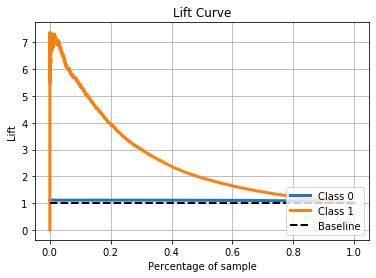

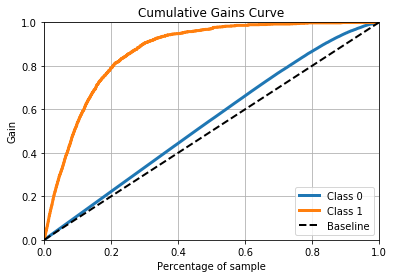

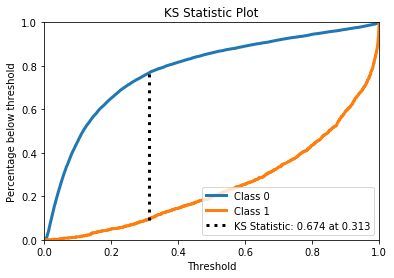

In [40]:
# logistical regression , no improvement 
os = SMOTE(random_state=0)
#Generate the oversample data
os_res_x,os_res_y=os.fit_sample(X_train[var_keep],y_train)
#Counts of each class in oversampled data
print(sorted(Counter(os_res_y).items()))

lr_clf = LogisticRegression(penalty = 'l2',random_state=1234)
build_model_train_test(lr_clf ,os_res_x,X_test[var_keep],os_res_y,y_test)

##### LR with SMOTE
    - high recall 81 and AUC 90.5, KS 67 , only a little improvement compared to LR with class_weight='balance'



##### Summary  for Modeing part : 
     - XG boost give us best model so far , with highest F1 /Recall score 71.
     Future  improvment : 
     - We can further turn  the hyperparameters using Grid Search  or other approach  to achieve best model performance later 
     - XG boost has Shap value  for model interpretation , for example : look at interactions etc 

----- Model Interpretation  -----
------------------


Text(0.5, 1.0, 'Feature importance visualization')

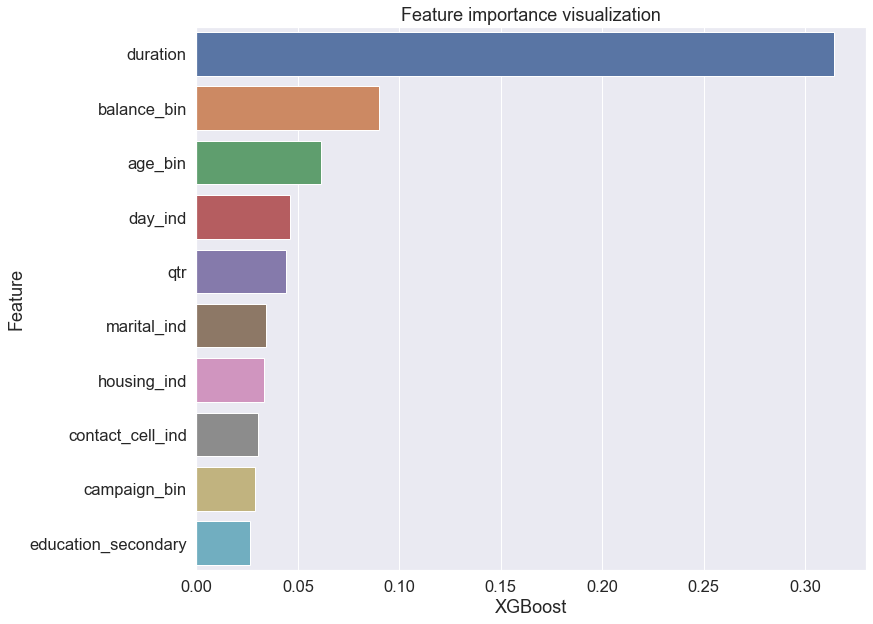

In [41]:
#plot xgboost feature importance 
sns.set(font_scale = 1.5)
plt.figure(figsize = (12,10))
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
sns.barplot(xgb_f.iloc[0:10,1],xgb_f.iloc[0:10,0])
plt.xlabel('XGBoost')
plt.ylabel('Feature')
plt.title('Feature importance visualization')

In [45]:
# EDA_test=x_test.copy()
# EDA_test['lr_pred']=probs_lr_test[:,1] 
# EDA_test['rf_pred']=probs_rf_test[:,1] 
# EDA_test['xgb_pred']=probs_xgb_test[:,1] 

In [46]:
# top 1 feature from XGBoost 
# univariate_numvar(EDA_test, 10,'duration',  'y', 'xgb_pred')

In [47]:
# eda_xs=[
#  'balance_bin',
#  'age_bin',
#  'day_ind',
#  'qtr',
#  'marital_ind',
#  'housing_ind',
#  'contact_cell_ind',
#  'campaign_bin']
# for x in eda_xs:
#       catplot(EDA_test,x,'xgb_pred',  plot=True)

In [ ]:
## data leakage due to duration : remove duration features , or combine with target 

## check variable which are highly correlated with 

--------------End ----------------------------